# **Transfer Learning Code Tutorial**

_This notebook contains all the sample code for the Deep learning Workshop: Trasnfer Learning._

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) # batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [52]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

TensorFlow version is  1.14.0


Datasets

In [0]:
# MNIST (Exersise 1)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [53]:
# Cats and Dogs (Exercise 2)
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 1s 0us/step


# Exercise 1

This exercise contains sample code from "Hands-On Machine Learning with Scikit-Learn & Tensorflow"

### Transfer learning w/ models saved from tensorflow

Let's create a simple neural net (w/gradient clipping) and pretrain it on the MNIST dataset

First we will create and save a model that is pretrain

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

In [0]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 200

In [23]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2878
1 Validation accuracy: 0.7938
2 Validation accuracy: 0.88
3 Validation accuracy: 0.9064
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.922
6 Validation accuracy: 0.9294
7 Validation accuracy: 0.936
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9564
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9616


Next we will reuse the saved model and continue training

In [0]:
reset_graph()

In [0]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [0]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

When developing model, can create a collection containing all important operations.

In [0]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [0]:
#The when reusing model can simple use get_collection()
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [35]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

0 Validation accuracy: 0.9638
1 Validation accuracy: 0.9634
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9648
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9692
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9716
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9714


Now lets try to reload the model, but now only using the initial layers and replacing the last hidden layer (layer 4) and the output layer. We will also change the loss and optimizer for the new output.

In [0]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [37]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy: 0.9192
1 Validation accuracy: 0.9394
2 Validation accuracy: 0.9486
3 Validation accuracy: 0.9528
4 Validation accuracy: 0.9554
5 Validation accuracy: 0.9556
6 Validation accuracy: 0.9576
7 Validation accuracy: 0.961
8 Validation accuracy: 0.9612
9 Validation accuracy: 0.9642
10 Validation accuracy: 0.965
11 Validation accuracy: 0.966
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9672
14 Validation accuracy: 0.9688
15 Validation accuracy: 0.9682
16 Validation accuracy: 0.9702
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.9704


### Transfer learning w/ weights from other frameworks

In [0]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [40]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [41]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [44]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

In [43]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Train with Lower Layers locked

Training using no layers locked

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [47]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9406
3 Validation accuracy: 0.9446
4 Validation accuracy: 0.9482
5 Validation accuracy: 0.9508
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.956
11 Validation accuracy: 0.9572
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9586
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.96
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9602


Now lets lock the first 3 hidden layers and only train the last hidden layer and output

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [51]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy: 0.9024
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.943
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.9568
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9582
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


# Exercise 2

This exercise contains sample code from TensorFlow's Tutorial "Transfer Learning Using Pretrained ConvNets". 

We will perform transfer learning on the cats/dogs dataset with a CNN model (MobileNet V2) that is pre-trained on the ImageNet dataset.

In [54]:
# Create the training and validation directories for cats datasets and dog datasets

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


In [55]:
# Define data generator to augmentat the dataset

image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Use pre-trained Feature Extractor Only

We will first download and load the pre-trained model and freeze its weights

In [56]:
# Create base mobel from pre-trained MobileNet V2
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
base_model.trainable = False

In [58]:
# View the structure of our model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Now let us add a new classification layer to the model for the cats/dogs dataset

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

As ususal we compile our model 

In [62]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)


W0827 18:17:39.947591 139821460305792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


2

Now we will train the model

In [63]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 11s 185ms/step - loss: 0.6174 - acc: 0.6636 - val_loss: 0.4744 - val_acc: 0.8075
Epoch 2/10
62/62 [==============================] - 7s 114ms/step - loss: 0.4994 - acc: 0.7754 - val_loss: 0.3819 - val_acc: 0.8649
Epoch 3/10
62/62 [==============================] - 7s 114ms/step - loss: 0.4105 - acc: 0.8425 - val_loss: 0.3181 - val_acc: 0.8881
Epoch 4/10
62/62 [==============================] - 7s 113ms/step - loss: 0.3642 - acc: 0.8770 - val_loss: 0.2956 - val_acc: 0.8901
Epoch 5/10
62/62 [==============================] - 7s 117ms/step - loss: 0.3172 - acc: 0.8913 - val_loss: 0.2632 - val_acc: 0.9022
Epoch 6/10
62/62 [==============================] - 7s 112ms/step - loss: 0.2992 - acc: 0.8918 - val_loss: 0.2337 - val_acc: 0.9113
Epoch 7/10
62/62 [==============================] - 7s 114ms/step - loss: 0.2602 - acc: 0.9116 - val_loss: 0.2282 - val_acc: 0.9113
Epoch 8/10
62/62 [==============================] - 7s 113ms/step - loss: 0

Visualize Learning Curve

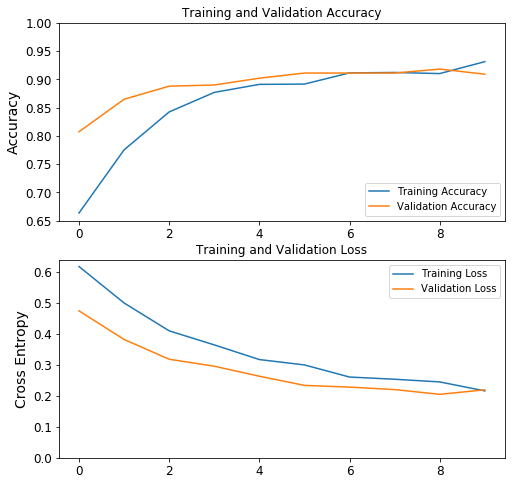

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Fine-Tuning

We will now try fine-tuning the higher-level features of our pre-trained model 

In [65]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


Similar to above we compile our model

In [66]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


58

Similar to above we train our model

In [67]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 12s 193ms/step - loss: 0.1585 - acc: 0.9461 - val_loss: 0.1199 - val_acc: 0.9597
Epoch 2/10
62/62 [==============================] - 7s 120ms/step - loss: 0.0843 - acc: 0.9731 - val_loss: 0.1192 - val_acc: 0.9567
Epoch 3/10
62/62 [==============================] - 7s 120ms/step - loss: 0.0582 - acc: 0.9868 - val_loss: 0.1125 - val_acc: 0.9587
Epoch 4/10
62/62 [==============================] - 7s 121ms/step - loss: 0.0483 - acc: 0.9863 - val_loss: 0.0976 - val_acc: 0.9688
Epoch 5/10
62/62 [==============================] - 7s 120ms/step - loss: 0.0253 - acc: 0.9949 - val_loss: 0.0957 - val_acc: 0.9688
Epoch 6/10
62/62 [==============================] - 8s 121ms/step - loss: 0.0185 - acc: 0.9949 - val_loss: 0.1031 - val_acc: 0.9677
Epoch 7/10
62/62 [==============================] - 8s 121ms/step - loss: 0.0139 - acc: 0.9985 - val_loss: 0.0983 - val_acc: 0.9708
Epoch 8/10
62/62 [==============================] - 8s 121ms/step - loss: 0

Visualize learning curve

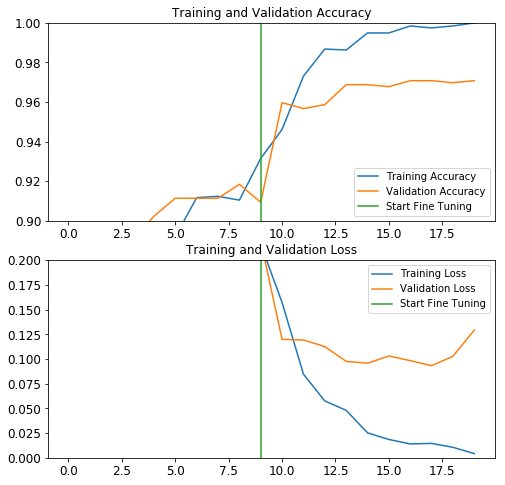

In [68]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Exercise 3

In this exercise we modify the prior example and use a different pre-trained model (Inception_Resnet- V2 w/imagenet dataset). 

In [0]:
# Create base mobel from pre-trained MobileNet V2
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model2 = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model2.trainable = False

In [71]:
base_model2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 79, 79, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 79, 79, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 79, 79, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [0]:
model2 = tf.keras.Sequential([
  base_model2,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [74]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()
len(model2.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


2

In [75]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 18s 286ms/step - loss: 0.0049 - acc: 0.9990 - val_loss: 0.2562 - val_acc: 0.9496
Epoch 2/10
62/62 [==============================] - 8s 122ms/step - loss: 0.0135 - acc: 0.9970 - val_loss: 0.1725 - val_acc: 0.9688
Epoch 3/10
62/62 [==============================] - 8s 122ms/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.1033 - val_acc: 0.9718
Epoch 4/10
62/62 [==============================] - 8s 123ms/step - loss: 0.0095 - acc: 0.9964 - val_loss: 0.1073 - val_acc: 0.9778
Epoch 5/10
62/62 [==============================] - 8s 126ms/step - loss: 0.0051 - acc: 0.9990 - val_loss: 0.1072 - val_acc: 0.9798
Epoch 6/10
62/62 [==============================] - 8s 124ms/step - loss: 0.0066 - acc: 0.9975 - val_loss: 0.1502 - val_acc: 0.9768
Epoch 7/10
62/62 [==============================] - 8s 124ms/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.1031 - val_acc: 0.9798
Epoch 8/10
62/62 [==============================] - 8s 125ms/step - loss: 0

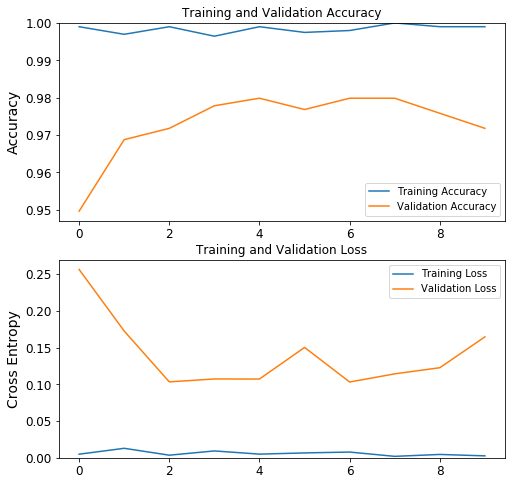

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()